Epoch 1/100
1592/1592 - 7s - loss: 0.0024 - 7s/epoch - 4ms/step
Epoch 2/100
1592/1592 - 6s - loss: 0.0014 - 6s/epoch - 4ms/step
Epoch 3/100
1592/1592 - 5s - loss: 0.0013 - 5s/epoch - 3ms/step
Epoch 4/100
1592/1592 - 5s - loss: 0.0015 - 5s/epoch - 3ms/step
Epoch 5/100
1592/1592 - 5s - loss: 0.0014 - 5s/epoch - 3ms/step
Epoch 6/100
1592/1592 - 5s - loss: 0.0012 - 5s/epoch - 3ms/step
Epoch 7/100
1592/1592 - 5s - loss: 0.0012 - 5s/epoch - 3ms/step
Epoch 8/100
1592/1592 - 5s - loss: 0.0011 - 5s/epoch - 3ms/step
Epoch 9/100
1592/1592 - 5s - loss: 9.3399e-04 - 5s/epoch - 3ms/step
Epoch 10/100
1592/1592 - 6s - loss: 0.0011 - 6s/epoch - 3ms/step
Epoch 11/100
1592/1592 - 6s - loss: 9.3007e-04 - 6s/epoch - 4ms/step
Epoch 12/100
1592/1592 - 5s - loss: 0.0011 - 5s/epoch - 3ms/step
Epoch 13/100
1592/1592 - 5s - loss: 0.0010 - 5s/epoch - 3ms/step
Epoch 14/100
1592/1592 - 5s - loss: 9.6142e-04 - 5s/epoch - 3ms/step
Epoch 15/100
1592/1592 - 5s - loss: 8.6027e-04 - 5s/epoch - 3ms/step
Epoch 16/100
1592/

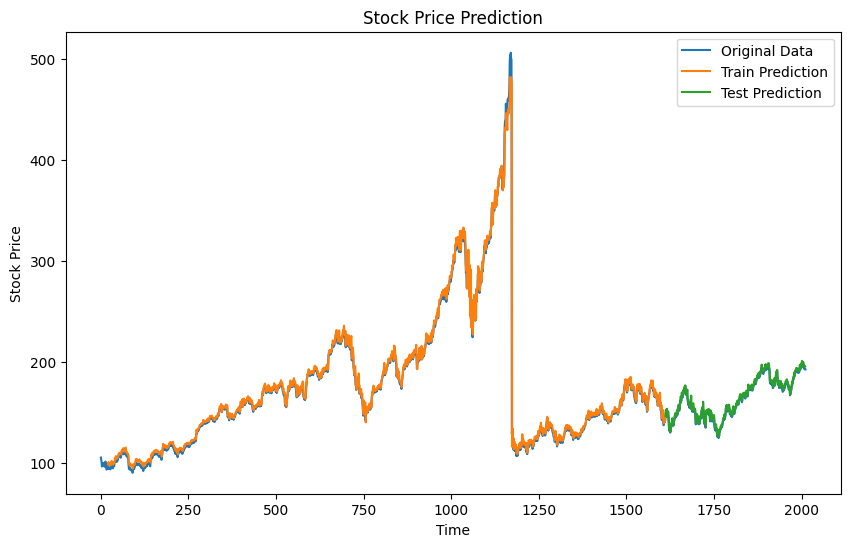

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
import alpaca_trade_api as alpaca

# Alpaca API credentials
API_KEY = 'PKU5LEIDZZV83Y5ENASI'
API_SECRET = 'nvzOwJpyvr73GTitTDyga0MkI2Qd6RsK4PmhItbu'
API_URL = 'https://paper-api.alpaca.markets'

# Initialize Alpaca API
alpaca_api = alpaca.REST(API_KEY, API_SECRET, API_URL, api_version='v2')

# Set the ticker symbols and timeframe
tickers = ["AAPL", "MSFT", "GOOG", "INTC", "NVDA"]
timeframe = "1Day"
start_date = "2016-01-01T00:00:00-00:00"
end_date = "2024-01-01T00:00:00-00:00"

# Retrieve the data
portfolio = pd.DataFrame(alpaca_api.get_bars(tickers, timeframe, start=start_date, end=end_date).df)

# Assuming 'portfolio' DataFrame needs to be indexed by ticker, let's filter for AAPL
aapl_data = portfolio[portfolio['symbol'] == 'AAPL']

# Prepare data for the RNN
data = aapl_data['close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Define the number of past days you want to consider for predicting the next day
look_back = 20

# Function to create dataset
def create_dataset(dataset, look_back=look_back):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Generate dataset
X, Y = create_dataset(data_scaled)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape input to be [samples, time steps, features]

# Split data into train and test sets
train_size = int(len(X) * 0.80)
test_size = len(X) - train_size
trainX, testX = X[0:train_size], X[train_size:len(X)]
trainY, testY = Y[0:train_size], Y[train_size:len(Y)]

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Train the model
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions to original scale
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Plotting
plt.figure(figsize=(10,6))

# Plot original scaled data
plt.plot(scaler.inverse_transform(data_scaled), label='Original Data')

# Setup plot arrays for train and test predictions
trainPredictPlot = np.empty_like(data_scaled)
trainPredictPlot[:, :] = np.nan
testPredictPlot = np.empty_like(data_scaled)
testPredictPlot[:, :] = np.nan

# Define the training end index for visual alignment in the plot
train_end_index = train_size + look_back

# Insert train predictions
trainPredictPlot[look_back:train_end_index, :] = trainPredict

# Define the test start index based on where training predictions end
test_start_index = train_end_index

# Ensure the test index range is valid by accommodating the exact length of testPredict
test_end_index = test_start_index + len(testPredict)

# Insert test predictions
testPredictPlot[test_start_index:test_end_index, :] = testPredict

# Plot train predictions
plt.plot(trainPredictPlot, label='Train Prediction')

# Plot test predictions
plt.plot(testPredictPlot, label='Test Prediction')

plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


Epoch 1/50
2070/2070 - 8s - loss: 0.0012 - 8s/epoch - 4ms/step
Epoch 2/50
2070/2070 - 7s - loss: 3.4459e-04 - 7s/epoch - 3ms/step
Epoch 3/50
2070/2070 - 7s - loss: 3.7031e-04 - 7s/epoch - 3ms/step
Epoch 4/50
2070/2070 - 7s - loss: 3.5302e-04 - 7s/epoch - 4ms/step
Epoch 5/50
2070/2070 - 7s - loss: 3.0277e-04 - 7s/epoch - 3ms/step
Epoch 6/50
2070/2070 - 6s - loss: 2.7626e-04 - 6s/epoch - 3ms/step
Epoch 7/50
2070/2070 - 7s - loss: 2.7964e-04 - 7s/epoch - 3ms/step
Epoch 8/50
2070/2070 - 6s - loss: 2.4759e-04 - 6s/epoch - 3ms/step
Epoch 9/50
2070/2070 - 7s - loss: 2.5063e-04 - 7s/epoch - 3ms/step
Epoch 10/50
2070/2070 - 6s - loss: 2.2360e-04 - 6s/epoch - 3ms/step
Epoch 11/50
2070/2070 - 7s - loss: 2.3728e-04 - 7s/epoch - 3ms/step
Epoch 12/50
2070/2070 - 6s - loss: 2.0648e-04 - 6s/epoch - 3ms/step
Epoch 13/50
2070/2070 - 7s - loss: 2.0264e-04 - 7s/epoch - 3ms/step
Epoch 14/50
2070/2070 - 7s - loss: 2.0757e-04 - 7s/epoch - 3ms/step
Epoch 15/50
2070/2070 - 7s - loss: 2.1077e-04 - 7s/epoch - 3m

1/1 [==============================] - 0s 484ms/step


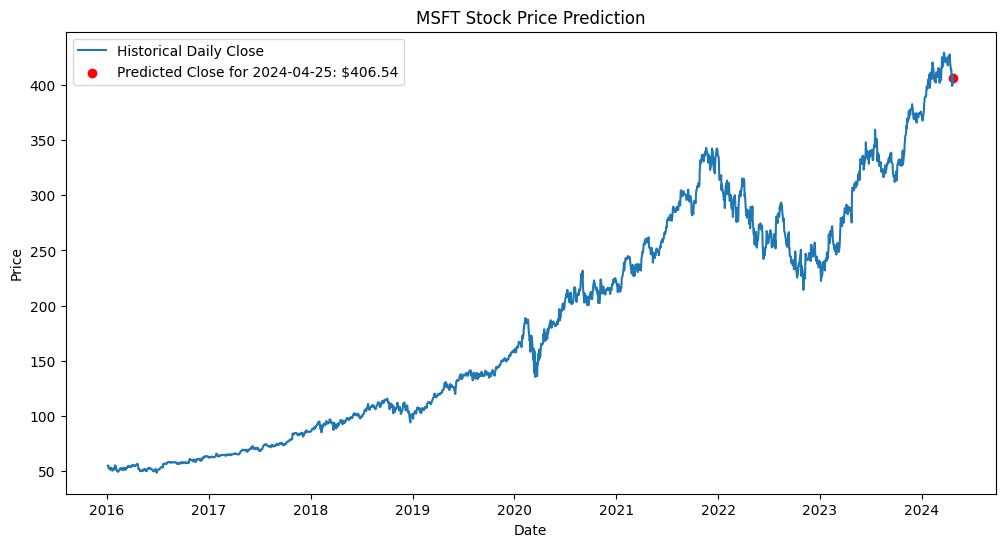

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
import alpaca_trade_api as alpaca

# Alpaca API credentials
API_KEY = 'PKU5LEIDZZV83Y5ENASI'
API_SECRET = 'nvzOwJpyvr73GTitTDyga0MkI2Qd6RsK4PmhItbu'
API_URL = 'https://paper-api.alpaca.markets'

# Initialize Alpaca API
alpaca_api = alpaca.REST(API_KEY, API_SECRET, API_URL, api_version='v2')

# Set the ticker symbols and timeframe
tickers = ["MSFT"]
timeframe = "1Day"
start_date = "2016-01-02T00:00:00-00:00"  # Adjusted date
end_date = "2024-04-24T00:00:00-00:00"    # Adjusted date

# Retrieve the data for Microsoft
msft_data = pd.DataFrame(alpaca_api.get_bars(tickers, timeframe, start=start_date, end=end_date).df)

# Prepare data for the RNN
data = msft_data['close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Function to create dataset
def create_dataset(dataset, look_back=20):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Generate dataset
X, Y = create_dataset(data_scaled)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape input to be [samples, time steps, features]

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(20, 1)))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Use the last 'look_back' days from the data as input to predict the next day
last_sequence = X[-1].reshape(1, 20, 1)

# Train the model (using more data and potentially more epochs may improve prediction accuracy)
model.fit(X, Y, epochs=50, batch_size=1, verbose=2)

# Predict the next day
next_day_prediction = model.predict(last_sequence)
next_day_prediction = scaler.inverse_transform(next_day_prediction)  # convert prediction back to stock price scale

# Plotting
plt.figure(figsize=(12,6))
plt.plot(msft_data['close'].index, msft_data['close'], label='Historical Daily Close')
plt.scatter(msft_data.index[-1] + pd.Timedelta(days=1), next_day_prediction, color='red', label=f'Predicted Close for 2024-04-25: ${next_day_prediction[0][0]:.2f}')
plt.title('MSFT Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [7]:
import pandas as pd
import alpaca_trade_api as alpaca

# Alpaca API credentials
API_KEY = 'PKU5LEIDZZV83Y5ENASI'
API_SECRET = 'nvzOwJpyvr73GTitTDyga0MkI2Qd6RsK4PmhItbu'
API_URL = 'https://paper-api.alpaca.markets'

# Initialize Alpaca API
alpaca_api = alpaca.REST(API_KEY, API_SECRET, API_URL, api_version='v2')

# Set the ticker symbol and timeframe for MSFT
ticker = ["MSFT"]
timeframe = "1Day"
start_date = "2016-01-01T00:00:00-00:00"  # Start at the beginning of January 2016
end_date = "2016-01-31T23:59:59-00:00"    # End at the end of January 2016

# Retrieve the data for Microsoft
msft_data_jan_2016 = pd.DataFrame(alpaca_api.get_bars(ticker, timeframe, start=start_date, end=end_date).df)

# Filter to get only the closing prices
msft_closing_prices_jan_2016 = msft_data_jan_2016[msft_data_jan_2016['symbol'] == 'MSFT']['close']

# Print the closing prices
print("MSFT Closing Prices for January 2016:")
print(msft_closing_prices_jan_2016)


MSFT Closing Prices for January 2016:
timestamp
2016-01-04 05:00:00+00:00    54.800
2016-01-05 05:00:00+00:00    55.050
2016-01-06 05:00:00+00:00    54.050
2016-01-07 05:00:00+00:00    52.170
2016-01-08 05:00:00+00:00    52.330
2016-01-11 05:00:00+00:00    52.300
2016-01-12 05:00:00+00:00    52.780
2016-01-13 05:00:00+00:00    51.640
2016-01-14 05:00:00+00:00    53.110
2016-01-15 05:00:00+00:00    50.990
2016-01-19 05:00:00+00:00    50.560
2016-01-20 05:00:00+00:00    50.790
2016-01-21 05:00:00+00:00    50.480
2016-01-22 05:00:00+00:00    52.290
2016-01-25 05:00:00+00:00    51.790
2016-01-26 05:00:00+00:00    52.170
2016-01-27 05:00:00+00:00    51.220
2016-01-28 05:00:00+00:00    52.055
2016-01-29 05:00:00+00:00    55.090
Name: close, dtype: float64


[*********************100%%**********************]  1 of 1 completed


Epoch 1/50
2081/2081 - 8s - loss: 0.0010 - 8s/epoch - 4ms/step
Epoch 2/50
2081/2081 - 7s - loss: 3.5928e-04 - 7s/epoch - 3ms/step
Epoch 3/50
2081/2081 - 7s - loss: 4.1665e-04 - 7s/epoch - 3ms/step
Epoch 4/50
2081/2081 - 6s - loss: 2.9576e-04 - 6s/epoch - 3ms/step
Epoch 5/50
2081/2081 - 7s - loss: 3.0426e-04 - 7s/epoch - 3ms/step
Epoch 6/50
2081/2081 - 6s - loss: 2.8277e-04 - 6s/epoch - 3ms/step
Epoch 7/50
2081/2081 - 8s - loss: 2.3826e-04 - 8s/epoch - 4ms/step
Epoch 8/50
2081/2081 - 6s - loss: 2.5896e-04 - 6s/epoch - 3ms/step
Epoch 9/50
2081/2081 - 6s - loss: 2.3946e-04 - 6s/epoch - 3ms/step
Epoch 10/50
2081/2081 - 6s - loss: 2.0848e-04 - 6s/epoch - 3ms/step
Epoch 11/50
2081/2081 - 6s - loss: 2.2368e-04 - 6s/epoch - 3ms/step
Epoch 12/50
2081/2081 - 6s - loss: 2.1158e-04 - 6s/epoch - 3ms/step
Epoch 13/50
2081/2081 - 6s - loss: 2.1882e-04 - 6s/epoch - 3ms/step
Epoch 14/50
2081/2081 - 6s - loss: 2.1387e-04 - 6s/epoch - 3ms/step
Epoch 15/50
2081/2081 - 6s - loss: 2.0223e-04 - 6s/epoch - 3m

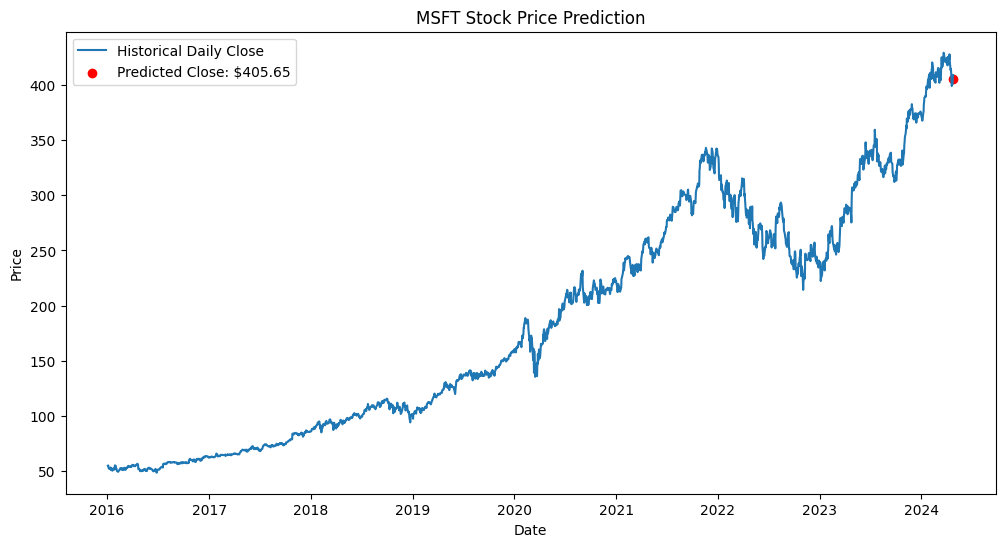

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
import yfinance as yf

# Fetch data using Yahoo Finance
ticker = "MSFT"
start_date = "2016-01-02"  # Start date
end_date = "2024-04-25"    # End date

# Retrieve the data for Microsoft
msft_data = yf.download(ticker, start=start_date, end=end_date)

# Prepare data for the RNN
data = msft_data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Function to create dataset
def create_dataset(dataset, look_back=10):  # Reduced look_back
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Generate dataset
X, Y = create_dataset(data_scaled)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape input to be [samples, time steps, features]

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(10, 1)))  # Adjusted input shape
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Use the last 'look_back' days from the data as input to predict the next day
last_sequence = X[-1].reshape(1, 10, 1)  # Adjusted input shape

# Train the model
model.fit(X, Y, epochs=50, batch_size=1, verbose=2)

# Predict the next day
next_day_prediction = model.predict(last_sequence)
next_day_prediction = scaler.inverse_transform(next_day_prediction)  # Convert prediction back to stock price scale

# Plotting
plt.figure(figsize=(12,6))
plt.plot(msft_data['Close'].index, msft_data['Close'], label='Historical Daily Close')
plt.scatter(msft_data.index[-1] + pd.Timedelta(days=1), next_day_prediction, color='red', label=f'Predicted Close: ${next_day_prediction[0][0]:.2f}')
plt.title('MSFT Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
